# Trabajo práctico 1 



**Human activity recognition**

https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/intro_ia/tree/cohorte-6/clase_2/jupyterbooks/data

**MNIST**

    from sklearn.datasets import fetch_openml
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


Deben maximizarse la cantidad de operaciones vectorizadas en las implementaciones.


## Ejercicio 1 - Implementar clase PCA con numpy
**Dataset** Human activity recognition

Tomar las primeras 63 componentes principales y calcular la varianza contemplada. Realizar las operaciones internas con numpy.linalg. 

In [1]:
import os
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
PATH_DATASET = "./UCI HAR Dataset/train"
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

In [3]:
#X_train.shape
#np.mean(X_train, axis=0).shape

print("X_train original mean: ", np.mean(X_train))
print("X_train original std deviation: ", np.std(X_train))

# Resto el valor medio de cada columna
X = X_train - np.mean(X_train, axis=0)

# Normalizo
X = X / np.std(X, axis=0)


print("X mean after normalization: ", np.mean(X))
print("X std after normalization: ", np.std(X))

X_train original mean:  -0.5083650377341108
X_train original std deviation:  0.5308743601104324
X mean after normalization:  2.095523536333411e-15
X std after normalization:  0.9999999999999999


In [4]:
# Calculo la matriz de covarianza
# S = np.dot(X.T, X)
S = np.cov(X.T)

# Calculo los autovalores y autovectores de la matriz de covarianza
s_eigvals, s_eigvecs = np.linalg.eig(S)

# Ordeno el vector de autovalores de mayor a menor
idx = s_eigvals.argsort()[::-1]   
s_eigvals = s_eigvals[idx]
s_eigvecs = s_eigvecs[:,idx]

In [5]:
# Calculo la proporcion de varianza aportada por cada feature
sum_eigenvalues = np.sum(s_eigvals)
prop_var = [i/sum_eigenvalues for i in s_eigvals]

# Calculo la varianza acumulada
cum_var = [np.sum(prop_var[:i+1]) for i in range(len(prop_var))]

D:\ProgramFiles\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


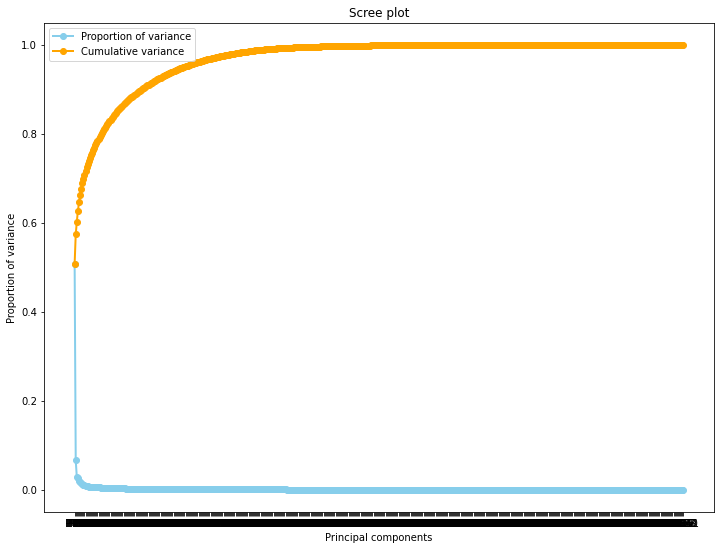

In [6]:
# Ploteo la varianza acumulada y la proporcion por cada feature

x_labels = ['PC{}'.format(i+1) for i in range(len(prop_var))]

plt.plot(x_labels, prop_var, marker='o', markersize=6, color='skyblue', linewidth=2, label='Proportion of variance')
plt.plot(x_labels, cum_var, marker='o', color='orange', linewidth=2, label="Cumulative variance")
plt.legend()
plt.title('Scree plot')
plt.xlabel('Principal components')
plt.ylabel('Proportion of variance')
plt.show()

In [7]:
# Las primeras 63 componentes aportan el 90% de la varianza
print(cum_var[62].real * 100)

90.0534506614594


In [8]:
index = 0
for i in range(len(cum_var)):
    if (cum_var[i].real < 0.901):
        index = i
        
main_comp = index + 1
print(main_comp)

63


In [9]:
# Proyectar el dataset centrado sobre los m=index autovectores mas relevantes
#D = np.diag(s_eigvals)
print(s_eigvecs.shape)
P = s_eigvecs[:,:main_comp]
print(P.shape)

X_new = np.dot(X, P)

X_new.shape

(561, 561)
(561, 63)


(7352, 63)

In [10]:
# Consolidar los pasos anteriores en una función o clase PCA
def my_PCA(data_set, req_var=0.9):
    """ Implement PCA algorithm over given data_set.
       
        Arguments:
            data_set: matrix of data to analize [n_samples,n_features].
            req_var: amount of variance to preserve (i.e. 0.9).
        
        Returns:
            X_new: reduced dataset [n_samples,m_features].
            main_comp: number of main components retained.
    """
    # Subtract mean value of each column
    X = data_set - np.mean(data_set, axis=0)
    # Normalize
    X = X / np.std(X, axis=0)
    
    # Calculate covariance matrix
    S = np.cov(X.T)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    s_eigvals, s_eigvecs = np.linalg.eig(S)

    # Sort eigenvalues and its eigenvectors in descending order (from largest to smallest). 
    idx = s_eigvals.argsort()[::-1]   
    s_eigvals = s_eigvals[idx]
    s_eigvecs = s_eigvecs[:,idx]

    # Calculate the proportion of variance explained by each feature
    sum_eigenvalues = np.sum(s_eigvals)
    prop_var = [i/sum_eigenvalues for i in s_eigvals]

    # Calculate the cumulative variance
    cum_var = [np.sum(prop_var[:i+1]) for i in range(len(prop_var))]

    index = 0
    for i in range(len(cum_var)):
        if (cum_var[i].real < (req_var+0.001)):
            index = i

    main_comp = index + 1

    P = s_eigvecs[:,:main_comp]

    X_new = np.dot(X, P)
    
    return X_new, main_comp

In [11]:
PATH_DATASET = "./UCI HAR Dataset/train"
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

[X_new, n_comp] = my_PCA(X_train, 0.9)
print(n_comp)
print(X_new.shape)

63
(7352, 63)


## Ejercicio 2 - Implementar clase KMeans con numpy
**Dataset** Human activity recognition

Implementar kmeans con numpy. Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de k=2 y 6. Graficar los casos de k=2 y k=6 con las primeras dos componentes principales.

In [12]:
def initialize_clusters(points, k):
    """Initializes clusters as k randomly selected points from points."""
    return points[np.random.randint(points.shape[0], size=k)]
    
# Function for calculating the distance between centroids
def get_distances(centroid, points):
    """Returns the distance the centroid is from each data point in points."""
    return np.linalg.norm(points - centroid, axis=1)

def my_KMEANS(X, k, max_iter):
    """ Implement k-mean clustering algorithm over the given data_set .
    
        Arguments:
            X: data set to cluster [n_samples,n_features].
            k: Number of clusters to use.
            max_iter: Number of iterations to perform.
        
        Returns:
            centroids: List with the positions of the centroids.
            classes: Array with the number of cluster for each row of the dataset 
    """

    # Initialize the centroids by picking random data points
    centroids = initialize_clusters(X, k)

    # Initialize the vectors to store the assigned classes of each data point
    # and the calculated distances from each centroid
    classes = np.zeros(X.shape[0], dtype=np.float64)
    distances = np.zeros([X.shape[0], k], dtype=np.float64)

    # Loop for the maximum number of iterations
    for i in range(max_iter):

        # Assign all points to the nearest centroid
        for i, c in enumerate(centroids):
            distances[:, i] = get_distances(c, X)

        # Determine class membership of each point
        # by picking the closest centroid
        classes = np.argmin(distances, axis=1)

        # Update centroid location using the newly
        # assigned data point classes
        for c in range(k):
            centroids[c] = np.mean(X[classes == c], 0)
    
    return centroids, classes

D:\ProgramFiles\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, '$x_1$')

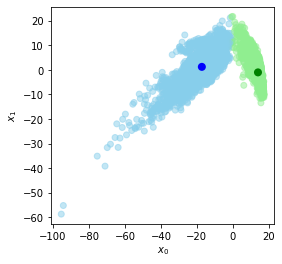

In [13]:
# K=2

PATH_DATASET = "./UCI HAR Dataset/train"
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

[X_new, n_comp] = my_PCA(X_train, 0.9)

[centroids, cluster_idx] = my_KMEANS(X_new, k=2, max_iter=10)

group_colors = ['skyblue', 'lightgreen']
colors = [group_colors[j] for j in cluster_idx]

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X_new[:,0], X_new[:,1], color=colors, alpha=0.5)
ax.scatter(centroids[:,0], centroids[:,1], color=['blue', 'green'], marker='o', lw=2)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

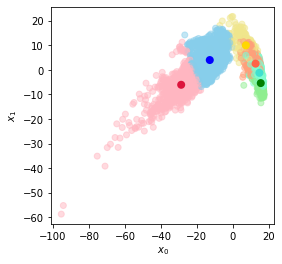

In [14]:
# K=6

PATH_DATASET = "./UCI HAR Dataset/train"
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

[X_new, n_comp] = my_PCA(X_train, 0.9)

[centroids, cluster_idx] = my_KMEANS(X_new, k=6, max_iter=100)

group_colors = ['skyblue', 'lightgreen', 'lightpink', 'lightsalmon', 'khaki', 'aquamarine']
colors = [group_colors[j] for j in cluster_idx]

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X_new[:,0], X_new[:,1], color=colors, alpha=0.5)
ax.scatter(centroids[:,0], centroids[:,1], color=['blue', 'green', 'crimson', 'tomato', 'gold', 'turquoise'], marker='o', lw=2)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$');

## Ejercicio 3 - Comparar los ejercicios anteriores con lo visto en las clases

- Con 63 features se obtuvo el 90% de la varianza al igual que en la práctica.
- Se observan dos grupos muy marcados que estan relacionados con las actividades de reposo y movimiento. Esto queda en evidencia cuando k=2.
- Los datos se observan rotados respecto a los vistos en clase.



## Ejercicio 4 - PCA + KMeans

**Dataset**: MNIST

Con las implementaciones de sklearn, tomar las componentes principales que capturen el 90% de la varianza y aplicar kmeans para agrupar los dígitos en 10 clusters. Analizar los resultados. 

In [42]:
# Import sklearn packages
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

In [43]:
# Import dataset
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [44]:
print('Formato del dataset: {}'.format(X.shape))
print('Formato de las etiquetas: {}'.format(y.shape))

Formato del dataset: (70000, 784)
Formato de las etiquetas: (70000,)


In [45]:
# Estandarizo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [46]:
# Aplico PSA conservando un 90% de la varianza
RANDOM_STATE = 17
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [47]:
# Cantidad de componentes necesarios
X_pca.shape[1]

238

In [48]:
# The number of clusters is suposed to be 10 (numbers from 0 to 9)
# This is confirmed here with the labels of the dataset
n_clusters = np.unique(y)
n_clusters

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [49]:
# Clusterizacion
kmeans = KMeans(n_clusters=10, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

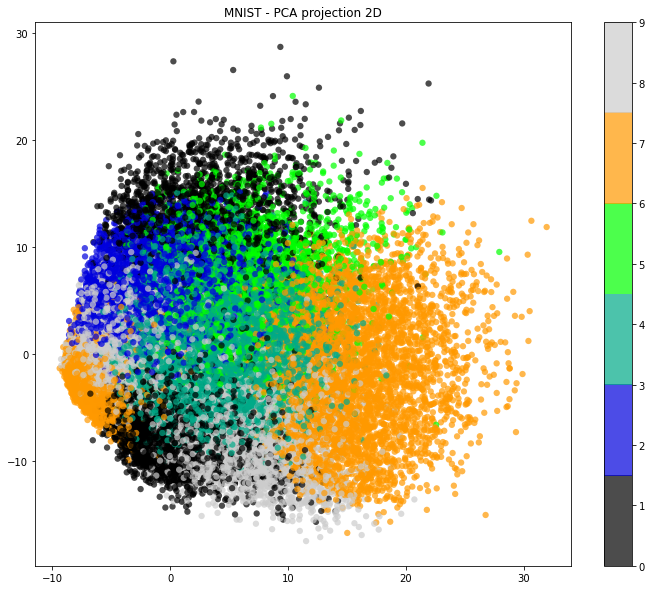

In [50]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('MNIST - PCA projection 2D');

In [51]:
import pandas as pd
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.columns = ['cluster ' + str(i + 0) for i in range(10)] + ['Todos']
tab

cluster 0  cluster 1  cluster 2  cluster 3  cluster 4  cluster 5  \
row_0                                                                     
0             10        664         13       1322        358        116   
1              1        159          7         28         16         13   
2             40         85        190        731        849       2376   
3            105        119        196       4110         88        727   
4            343        944       3991          5        128         73   
5             64       2709        312       2134        102        243   
6              5        139         27        108       5316        425   
7            916        127       1610         10          3         15   
8             73       2097        359       2595         31        197   
9            431        127       3511        124          5         23   
All         1988       7170      10216      11167       6896       4208   

       cluster 6  cluster 7  cluster 8  cluster 9  Todos  
row_0                                                     
0             35       3906        473          6   6903  
1           7638          0         10          5   7877  
2            829         40       1820         30   6990  
3            575         11       1116         94   7141  
4            535         57         27        721   6824  
5            467         33        159         90   6313  
6            560        283         12          1   6876  
7            523         20         13       4056   7293  
8           1168         45         78        182   6825  
9            339         44         14       2340   6958  
All        12669       4439       3722       7525  70000

## Observaciones
A simple vista no parece que la clusterización haya logrado separar los 10 dígitos de manera exitosa, al menos no al 100%. Se pueden observar ciertas tendencias como que por ejemplo la gran mayoría de las imágenes etiquetadas como "1" se encuentran en el cluster 6. Pero en otros casos se ve que los ditos están distribuidos entre más de un cluster, como es el caso del número "9" que estan repartidos entre los clusters 2 y 9.

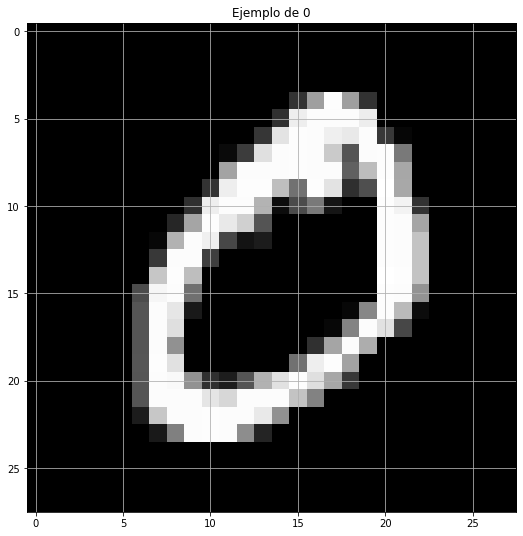

In [52]:
# Cargamos una muestra
plt.grid(True)
plt.title("Ejemplo de {}".format(y[1]))
plt.imshow(X[1, :].reshape((28, 28)), cmap='gray')

In [58]:
for i in range(50):
    print("Cluster: ",cluster_labels[i],"Etiqueta: ", y[i])

Cluster:  1 Etiqueta:  5
Cluster:  7 Etiqueta:  0
Cluster:  0 Etiqueta:  4
Cluster:  6 Etiqueta:  1
Cluster:  2 Etiqueta:  9
Cluster:  8 Etiqueta:  2
Cluster:  6 Etiqueta:  1
Cluster:  3 Etiqueta:  3
Cluster:  6 Etiqueta:  1
Cluster:  1 Etiqueta:  4
Cluster:  3 Etiqueta:  3
Cluster:  1 Etiqueta:  5
Cluster:  5 Etiqueta:  3
Cluster:  4 Etiqueta:  6
Cluster:  6 Etiqueta:  1
Cluster:  9 Etiqueta:  7
Cluster:  3 Etiqueta:  2
Cluster:  1 Etiqueta:  8
Cluster:  4 Etiqueta:  6
Cluster:  9 Etiqueta:  9
Cluster:  0 Etiqueta:  4
Cluster:  7 Etiqueta:  0
Cluster:  9 Etiqueta:  9
Cluster:  6 Etiqueta:  1
Cluster:  6 Etiqueta:  1
Cluster:  3 Etiqueta:  2
Cluster:  2 Etiqueta:  4
Cluster:  3 Etiqueta:  3
Cluster:  5 Etiqueta:  2
Cluster:  6 Etiqueta:  7
Cluster:  0 Etiqueta:  3
Cluster:  1 Etiqueta:  8
Cluster:  4 Etiqueta:  6
Cluster:  9 Etiqueta:  9
Cluster:  1 Etiqueta:  0
Cluster:  1 Etiqueta:  5
Cluster:  4 Etiqueta:  6
Cluster:  1 Etiqueta:  0
Cluster:  2 Etiqueta:  7
Cluster:  4 Etiqueta:  6
